<h1> Project: Housing Evictions and Fair Market Rents in New York City</h1> <a id=7></a>
<h3> Memo Draft</h3>


## Table of Contents 

<div class = "alert alert-info">

1. [Introduction](#1)<br>
2. [Research Question](#2)<br>
    2.1 [Assumptions](#2.1)<br>
3. [Data](#3)<br>
    3.1 [Univariate Analysis](#3.1)<br>
    3.2 [Mapping Analysis](#3.2)<br>
4. [Data Analysis](#4)<br>
    4.1 [Bivariate Analysis](#4.1)<br>
    4.2 [Multivariate Analysis](#4.2)<br>
5. [Summary Conclusions](#5)<br>
6. [References](#6)<br>
    
</div>
<hr>

## Introduction <a id=1></a>
In the wake of the COVID-19 pandemic, New Yorkers have feared a rise in housing evictions across the city as landlords attempt to recover their losses and forcibly evict tenants.  As housing courts have reopened and the eviction deferment period is long passed, we are now seeing a rise in evictions across the city.  According to a NY Times article, the housing chaos began this spring:<br> 
> "The roughly 2,000 eviction cases filed by landlords every week since March are roughly 40 percent more than the number filed in mid-January [2022], after the state’s eviction moratorium expired. Tenants have been thrown out of homes in more than 500 cases since February, according to city data, about double the number in all of the 20 months prior." (Zaveri, 2022)

In this project we will attempt to test the relationship of housing evictions to a variety of neighborhood demographics including changes in the fair market housing rates (FMR) through exploratory data analysis (EDA) using data selected from the <b>Eviction Lab</b>, <b>ACS</b> and the <b>Housing and Urban Development</b> (HUD) datasets. 

## Data <a id=3></a>

For this project, we are utilizing data from two datasets (evictionlab.org and HUD) that both include zip code geolocators, in order to both map and analyze the data.  In order to make this happen, we needed to utilize a "crosswalk" dataset from HUD.gov in order to connect geographic areas.  Additionally, we will use ACS data for demographic information within each area.

Our first task is to read in and inspect the merged <b>Eviction Lab</b> and <b>FMR</b> dataset.  In the eviction dataset, there are 8428 unique observations and 7 variables, and in the merged dataset, there are 9744 observations across 21 columns.  

In [1]:
import pandas as pd         #quick stats       
import numpy as np      #numerical functions
import matplotlib.pyplot as plt    #visualization library
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns    #visualization and stats

In [2]:
%matplotlib inline

In [3]:
#load merged dataset--parquet
path = '/Users/ameliaingram/Documents/My_GitHub+Repository/eviction-rent/assets/data/evict_merged.parquet'

df = pd.read_parquet(path)            # read eviction data from online

In [4]:
df.info()                               # returns # rows/obs, columns/variables and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8729 entries, 0 to 8728
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   city             8729 non-null   category      
 1   type             8729 non-null   category      
 2   geoid            8700 non-null   Int64         
 3   racial_majority  8700 non-null   category      
 4   month            8729 non-null   datetime64[ns]
 5   filings_2020     8729 non-null   int64         
 6   filings_avg      8729 non-null   float64       
 7   fmr_2br          2861 non-null   float64       
 8   fmr_2br_90       2861 non-null   float64       
 9   fmr_2br_110      2861 non-null   float64       
 10  borough          5133 non-null   category      
 11  post_office      5133 non-null   category      
 12  neighborhood     5133 non-null   category      
 13  population       5133 non-null   float64       
 14  density          5133 non-null   float64

Based on the listed info, there are 8729 unique observations in this dataset, with only 8700 including `GEOID`(zip code) data.  

There are two main issues we see above. First, we can observe `GEOID` cases are essentially zip codes and a number of `GEOID` cases that are listed as "sealed".  According to the data dictionary from the Eviction Lab website, "A modest portion of filings are reported to us with missing, incorrect, or out-of-bounds addresses. In these cases, we do not assign a Census Tract or Zip code to the case." There were 29 sealed cases excluded for the purposes of merging and mapping.  <b>NOTE:</b>  If we wish to use the sealed sets, we can load the `f_evict` dataset.<br>

Secondly, the `HUD Metro Area Name` actually changed for certain zip codes from year to year.  We kept those columns in the data for reference.  Not sure if it's important yet, but they're there.

The `month` variable includes both month and year data.  Will need to confirm they use Python's `datetime64` format.  The 'sealed' values from the `GEOID` column now has 896 null entries.  Hopefully this won't be a problem--it is relatively low.

### Check for missing values
Before any initial analysis, we need to check for missing values from each dataset. 

In [5]:
df.isnull().sum()        # confirm the number of NaN values for the df

city                  0
type                  0
geoid                29
racial_majority      29
month                 0
filings_2020          0
filings_avg           0
fmr_2br            5868
fmr_2br_90         5868
fmr_2br_110        5868
borough            3596
post_office        3596
neighborhood       3596
population         3596
density            3596
dtype: int64

In [10]:
#Convert 'geoid' sealed entries into NaN
df.geoid.replace('sealed', np.nan)

df['geoid'].isnull().sum()        # returns the number of NaN values for the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8729 entries, 0 to 8728
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   city             8729 non-null   category      
 1   type             8729 non-null   category      
 2   geoid            8700 non-null   Int64         
 3   racial_majority  8700 non-null   category      
 4   month            8729 non-null   datetime64[ns]
 5   filings_2020     8729 non-null   int64         
 6   filings_avg      8729 non-null   float64       
 7   fmr_2br          2861 non-null   float64       
 8   fmr_2br_90       2861 non-null   float64       
 9   fmr_2br_110      2861 non-null   float64       
 10  borough          5133 non-null   category      
 11  post_office      5133 non-null   category      
 12  neighborhood     5133 non-null   category      
 13  population       5133 non-null   float64       
 14  density          5133 non-null   float64

Now the variables are ready to perform an initial exploratory analysis.  

## Research Questions <a id=2></a>

For this project, we wish to investigate the following question:

> <b>Q1:</b>  Is there a correlation between eviction rates and any other demographic features of New York City neighborhoods that might indicate a further association to gentrification? <br>
> <b>Q2:</b>  Is there a correlation between eviction rates and fair housing rents in New York City? <br>


The variables from the evictionlab.org dataset which will be used to answer these questions are:
> <b>DV:</b>  eviction rates<br>
> <b>DV2:</b>  average fair market rent (FMR) for a 2 bedroom<br>

Eviction rates are defined as the number of evictions registered by the housing court within a given zip code.  These may not include forcible evictions that happen in unofficial living arrangements (such as "cash only" housing in illegal sublets, frequented by poor and undocumented populations). (*It is important to note that forced evictions are illegal in New York City, regardless of the type of housing arrangement. (For more information, see the Tenants Bill of Rights under the NYC Comptroller's Office.))

In order to better understand the relationship between these issues, we will experiment with several demographic control variables, including:
> <b>IV:</b> race <br>
> <b>IV:</b> zip code and/or neighborhood <br>
> <b>IV:</b> county <br>
> <b>IV:</b> length of time <br>

Others may be included as the project unfolds.

## Assumptions <a id=2.1></a>
Recent evidence produced from several housing research centers predict that there will be a strong increase in housing evictions in the New York City metropolitan area, despite the best efforts of both city and state agencies to prevent a massive rise in homelessness.  We assume that there could be some evidence of a relationship between incident areas where eviction rates are high and increases in fair market rent (FMR) that could potentially displace lower income communities and lead to further gentrification (or else be signs of future gentrification). In this case, we assume that a rise in fair market rent (FMR) will indicate displacement of low income populations from previously affordable subsidized housing. 

According to the U.S. Housing and Urban Development (HUD) Office of Policy Development and Research (see Summary), the FMR was implemented in 1974 to help low-income households find affordable housing. This is generally known as the Section 8 voucher system.  According to their Summary page, the FMR is defined as "the 40th percentile of gross rents for typical, non-substandard rental units occupied by recent movers in a local housing market." (Further information and problematics in the calculation of this rate are discussed on HUD's Summary page).

It is assumed that race also plays a crucial role in both eviction rates and rental rates.  Government and local experts have historically suggested this as a trend.  Recently, a report was published by the U.S. Commission on Civil Rights which outlines the recent issues of racial discrimination in evictions (2022).

Finally, for the purposes of this research we assume that the housing market in New York City is fixed (this is a reasonable assumption given the pandemic slowdown of new building construction).
  

## Descriptive Analysis <a id=3.1></a>

### 1. Variable:  Evictions (filings_2020)
`filings_2020` is the independent variable in this study.  The Eviction Lab data reports both `filings_2020` which is a cumulative number since 2020 and `filings_avg` which is the average per month.  We are exploring both versions in this project.]

In [11]:
df.filings_2020.describe()                          

count    8729.000000
mean       17.279872
std        40.566265
min         0.000000
25%         0.000000
50%         1.000000
75%        15.000000
max       550.000000
Name: filings_2020, dtype: float64

According to the preliminary descriptive statistics, evictions were on average 17.075 per zipcode, with a minimum of zero and a maximum of 550.  The interquartile range varied from 0 to 15 for the middle 50% of zipcodes.  

Text(0, 0.5, '# Evictions')

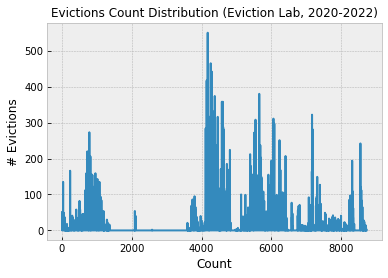

In [16]:
with plt.style.context('bmh'):      #temporary use of style sheet--source Matplotlib reference
    df.filings_2020.plot(kind='line')
plt.title('Evictions Count Distribution (Eviction Lab, 2020-2022)')
plt.xlabel('Count')
plt.ylabel('# Evictions')

After viewing the histogram, it is apparent that the vast majority of evictions are happening in the midrange of all zipcodes, however there are gaps.  This leads to a heavily left-skewed plot.

## Factoring Evictions
In order to refine the evictions into a recognizable pattern, I will first obtain a sum of evictions per zip code, then divide the total number of evictions from 2020-2022 by the average evictions in each zip code to obtain the differential percentage.  

Next, I will factor evictions into NINE categorical levels of evictions (-100 to -76%, -75 to -51%, -50 to -24%, -25 to -1%, 0, 25-49%, 50-74%, 75-100%, and >100%). This will give a more detailed attention to the extreme ranges of evictions, in order to isolate these groups from the lower rates.

In [18]:
df.groupby('geoid').sum()

,filings_2020,filings_avg,fmr_2br,fmr_2br_90,fmr_2br_110,population,density
geoid,,,,,,,
10001,494,1435.333333,72790.0,65511.0,80069.0,611958.0,984811.0
10002,861,4992.666667,50570.0,45513.0,55627.0,2360890.0,2684617.0
10003,405,1197.666667,89670.0,80703.0,98637.0,1624696.0,2818452.0
10004,47,100.666667,89670.0,80703.0,98637.0,89581.0,160051.0
10005,152,260.666667,89670.0,80703.0,98637.0,206915.0,2814392.0
...,...,...,...,...,...,...,...
11691,2044,7408.000000,0.0,0.0,0.0,1741015.0,614365.0
11692,370,2362.333333,0.0,0.0,0.0,537660.0,538414.0
11693,194,1007.333333,0.0,0.0,0.0,345564.0,346550.0


This worked to generate the count of filings_2020 by zip code, but it created an issue in the filings_avg by counting this column instead of producing an average.  So I'm going to try and do this with a groupby function.

In [ ]:
# Groupby geoid and find ratio of 
def evict_diff(x):
    # df is the Dataframe
    for x in df['geoid']:
        df['filings_2020'].sum() / df['filings_avg'].groupby(df['geoid']).mean()
    return x

filings_diff = df.groupby('geoid').apply(evict_diff))
print(filings_diff)

In [ ]:
#factor 
def evict_ratio(y):                                 
    '''
    INPUT: 
    y: int, from -100 to 100%, the outputs of the ratio in evict_diff for `filings_2020`
    
    OUTPUT:
    -.1 - -.76 recoded to '-100% to -76%'
    -.75 to -.51 recoded to '-75% to -51%'
    -.50 to -.24 recoded to '-50 to -24%'
    -.25 to -.01% recoded to '-25 to -1%'
    0 recoded to '0'
    .01-.24 recoded to '1-24%'
    .25-.49 recoded to '25-49%'
    .50-.74 recoded to '50-74%'
    .75-1.00 recoded to '75-100%'
    >1.00 recoded to '>100%'
    '''
    if y >= -.1 and y<-.76
        return '-100% to -76%'
    if y >= -.75 and y <= -.51
        return '-75- -51%'
    if y >= -.50 and y <= -.24
        return '-50- -24%'
    if y >= -.25 and y <= -.01
        return '-25- -1%'
    if y == 0:
        return '0'
    if y >0 and y<=.24:
        return '1-24%'
    elif y >= .25 and y<=.49:
        return '25-49%'
    elif y >= .50 and y<=.74:
        return '50-74%'
    elif y>=.75 and y<.10:
        return '75-100%'
    elif y>=.100:
        return '>100%'
    else:
        return np.nan                        # missing is coded as nan 

# apply the function to `filings_2020`

df['filings_ratio'] = df.filings_2020.apply(evict_ratio(filings_diff))

In [ ]:
# double check whether the transformation is successful:

df[['filings_ratio']]

Now that we have groups `filings_2020` into groups, let's see the resulting distribution. 

In [ ]:
with plt.style.context('fast'):
    df2.groupby('filings_cat').size().plot(kind='bar')   #bar graph in order
plt.title('Eviction Rates by Groups (Eviction Lab 2020-2022)')
plt.xlabel('Eviction by Groups')
plt.ylabel('# Evictions')

## 4. Data Analysis <a id=4></a>


## 4.1 Bivariate Analysis<a id=4.1></a>

After inpecting each variable, I performed some simple bivariate or multivariate distributions of the numerical variables (filings_2020) over different constants (race, month, political party).

- ### Eviction Rates and Race <br>

In [ ]:
df2.groupby('racial_majority')['filings_2020'].agg(['mean', 'median', 'max', 'min'])        # avg filings_2020 groupby race        

In order to better understand the distribution, it is also useful to visualize evictions and race in a boxplot.

In [ ]:
#boxplot of evictions IQR and mean grouped by race
#Changing the outlier markers
red_circle = dict(markerfacecolor='red', marker='o')
df2.boxplot(column='filings_2020', by='racial_majority', vert=False, showmeans=True, flierprops=red_circle)    # by: x axis, column: y axis
#plt.xscale('log')    #playing around with log on boxplot to see if it helps...it reduces outliers but makes it impossible to read TV hours
plt.title('Eviction Filings by Race (Eviction Lab, 2020-2022)')
plt.xlabel('Evictions')
plt.ylabel('Race')
plt.suptitle('')

In [ ]:
pd.crosstab(values=df2['id'],    #prop table/contingency table visualization
            index=df2['racial_majority'],
            columns=df2['filings_2020'],
            aggfunc='count',
            normalize='index').plot(kind='barh', 
                                   figsize=(8, 6), alpha=1,
                                   stacked=False)
plt.title('Evictions % by Race (Eviction Lab, 2020-2022)')
plt.xlabel('% Evictions')
plt.ylabel('Race')
plt.suptitle('')

- ### Evictions and Month
Evictions are assumed to be a year-round activity.  Let us see how the dates confirm or deny this assumption.


In [ ]:
pd.crosstab(values=df2['id'],    #prop table/contingency table
            index=df2['filings_2020'],
            columns=df2['month'],
            aggfunc='count',
            normalize='index')    # takes True, 'columns' (each col 100%), 'index' (each row 100%)

In [ ]:
pd.crosstab(values=df2['id'],    #prop table/contingency table visualization
            index=df2['filings_2020'],
            columns=df2['month'],
            aggfunc='count',
            normalize='index').plot(kind='barh', 
                                   figsize=(8, 6), alpha=0.7,
                                   stacked=True, color=(['Red', 'Blue']))
plt.title('Evictions % by Month (Eviction Lab, 2020-2022)')
plt.xlabel('%')
plt.ylabel('Month')
plt.suptitle('')

- ### Evictions and Political Party

The relationship between evictions and political party in American society is a contentious one.  With the support of the Republican party, police unions and the  military, a link is usually made between poverty and liberal politics.  Let us see how the data reflected these viewpoints.

In [ ]:
pd.crosstab(values=df2['id'],    #prop table/contingency table
            index=df2['filings_2020'],
            columns=df2['party'],
            aggfunc='count',
            normalize='index')    # takes True, 'columns' (each col 100%), 'index' (each row 100%)

 ## 4.2 Multivariate Analysis <a id=4.2></a>

For the final portion of exploratory analysis, I will explore the strength of relationships between multiple variables.  

- <b> Evictions + County + Race</b><br>
First, I will look at the relationship of eviction filings grouped by county and race.  

In [ ]:
import scipy.stats as stats               # a statistical analysis library

In [ ]:
df.groupby(['county', 'race'])['filings_2020'].agg(['mean', 'median', 'max', 'min'])         # avg tvhours groupby race and owngun

## 6. References <a id=6></a>

### Programming References:
Matplotlib Style Sheets Reference.  https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

Legend in Matplotlib.  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html

Stats t-test in Scipy.  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html


### Datasets:
Crosswalk Dataset of Zip to Tract. U.S. Department of Housing and Urban Development. Office of Policy Development and Research.  https://www.huduser.gov/portal/datasets/usps_crosswalk.html#data

"Fair Market Rents: 40th Percentile." U.S. Department of Housing and Urban Development. Office of Policy Development and Research. Datasets.  https://www.huduser.gov/portal/datasets/fmr.html#2022_data

Peter Hepburn, Renee Louis, and Matthew Desmond. Eviction Tracking System: Version 1.0. Princeton: Princeton University, 2020. www.evictionlab.org.

### General Reference
"Summary: Fair Market Rents." U.S. Department of Housing and Urban Development. Office of Policy Development and Research. Blog.  https://www.huduser.gov/periodicals/ushmc/winter98/summary-2.html 

U.S. Commission on Civil Rights. Racial Discrimination and Eviction Policies and Enforcement in New York. 10 Mar 2022.  https://www.usccr.gov/reports/2022/racial-discrimination-and-eviction-policies-and-enforcement-new-york

Zaveri, Mihir.  After a Two-Year Dip, Evictions Accelerate in New York. The New York Times. 2 May 2022. https://www.nytimes.com/2022/05/02/nyregion/new-york-evictions-cases.html


<div class = "alert alert-info">

[Back to top](#7)<br>
    
</div>
<hr>